In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from utils import load_dataset, aggregate, plot_quantiles, plot_surface, plot_common
import matplotlib.pyplot as plt
from IPython.display import Markdown

algorithm = 'minfilter3d'
pd.set_option('display.max_rows', 10000)
data = load_dataset('csv', 'minfilter_test_2048x2048x')
data = data[data['size'].isin([1, 2, 4, 6, 8]) & data['image_size'].isin([10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000])]
data = data[~((data['method'] == 'clij') & (data['image_size'] == 500))]

## Comparison between methods

<module 'matplotlib.pyplot' from '/usr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

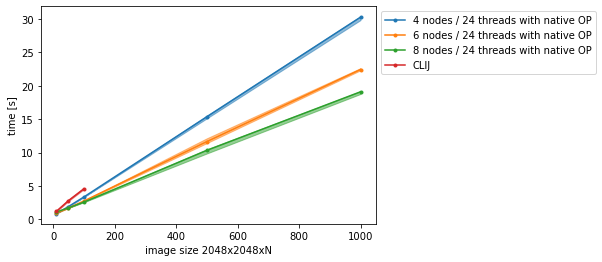

In [2]:
def plot(with_java):
    global idx
    idx = 0
    def plot_q(method, node, label):
        global idx
        p2, p5, p8 = [(aggregate(data[data['size'] == node], method=method, stat='total_op', aggfunc=lambda x: x.quantile(q))/1000) for q in [0.2, 0.5, 0.8]]
        plt.plot(p5, marker='.', label=label)
        plt.fill_between(p8.index, p8[node], p2[node], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][idx], alpha=0.5)
        idx += 1

    for nodes in [4, 6, 8]:
        plot_q('nativempi', nodes, f'{nodes} nodes / 24 threads with native OP')

    plot_q('clij', 1, 'CLIJ')

    if with_java:
        plot_q('default', 1, 'default 1 node')
        for nodes in [2, 4, 6, 8]:
            plot_q('mpi', nodes, f'{nodes} nodes / 24 threads')

    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.xlabel('image size 2048x2048xN')
    plt.ylabel('time [s]')
    return plt

plot(with_java=False)

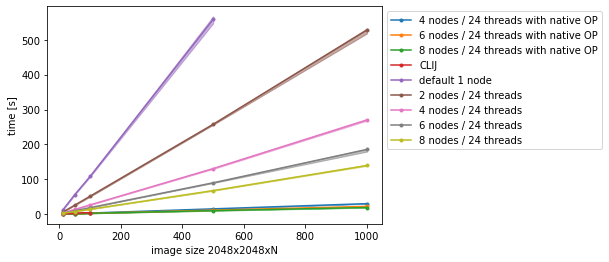

In [3]:
plot(with_java=True).savefig(f'figures/{algorithm}_comparison.pdf', bbox_inches='tight')

## Measured time with CLIJ

Text(0, 0.5, 'time [s]')

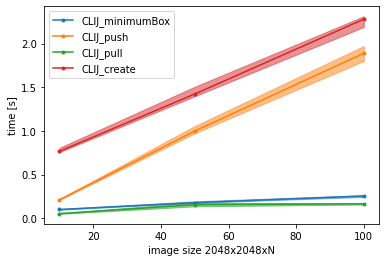

In [4]:
for i, stat in enumerate(['CLIJ_minimumBox', 'CLIJ_push', 'CLIJ_pull', 'CLIJ_create']):
    p2, p5, p8 = [(aggregate(data, method='clij', stat=stat, aggfunc=lambda x: x.quantile(q))/1000) for q in [0.2, 0.5, 0.8]]
    plt.plot(p5, marker='.', label=stat)
    plt.fill_between(p8.index, p8[1], p2[1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], alpha=0.5)
plt.legend()
plt.xlabel('image size 2048x2048xN')
plt.ylabel('time [s]')

## Measured time with native OP

Text(0, 0.5, 'time [s]')

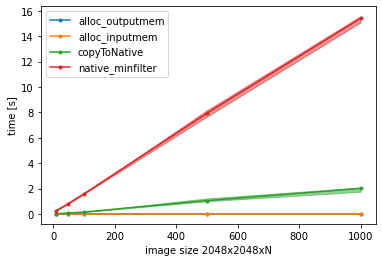

In [5]:
for i, stat in enumerate(['alloc_outputmem', 'alloc_inputmem', 'copyToNative', 'native_minfilter']):
    p2, p5, p8 = [(aggregate(data, method='nativempi', stat=stat, aggfunc=lambda x: x.quantile(q))/1000) for q in [0.2, 0.5, 0.8]]
    plt.plot(p5[8], marker='.', label=stat)
    plt.fill_between(p8.index, p8[8], p2[8], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], alpha=0.5)
plt.legend()
plt.xlabel('image size 2048x2048xN')
plt.ylabel('time [s]')